# Load lib

In [1]:
from si_prefix import si_format
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from qiskit import pulse, assemble

from qiskit.tools.monitor import job_monitor

In [13]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
# GHz = 1.0e9 # Gigahertz
# MHz = 1.0e6 # Megahertz
# us = 1.0e-6 # Microseconds
# ns = 1.0e-9 # Nanoseconds

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [3]:
# from qiskit.tools.jupyter import * 
from qiskit.test.mock import FakeArmonk, FakeVigo

# Account setup and list of backends

In [4]:
from qiskit import IBMQ
# apitoken='5796668ee5b1b6c42dba99e7aa77bfdc8c980d7ce767895fa79b2971797ab08a6ab6e8b4db870153cb724887818d1cee5090c909f7d2fb610d9b128e0bd41b63'
apitoken='012bc8169d88d9d510702a497ec8311cf15f974c9885732420a126c8e8d682662235c3788a6b78338bfebafcbe754d13d7d80e841252d905efda5c0d977a1d3f'

try:
    IBMQ.enable_account(token=apitoken)
except:
    pass

IBMQ.providers()

C:\Users\racco\AppData\Roaming\Python\Python37\site-packages\qiskit\providers\ibmq\ibmqfactory.py:109: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science')>]

In [ ]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
provider.backends()

# backend = FakeArmonk()
backend = provider.get_backend('ibmq_armonk')
# backend = provider.get_backend('ibmq_casablanca')

backend_config = backend.configuration()
# assert backend_config.open_pulse, "Backend doesn't support Pulse"

# Load system values

In [7]:
dt = backend_config.dt
print("Sampling time: {}s".format(si_format(dt)))    
backend_defaults = backend.defaults()

Sampling time: 222.2 ps


In [8]:
qubit = 0

In [9]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [10]:
# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print("Qubit {} has an estimated frequency of {}Hz.".format(qubit,si_format(center_frequency_Hz,3)))

Qubit 0 has an estimated frequency of 4.822 GHz.


# Define sweep

We will sweep 20 MHz above and 20 MHz below the estimated frequency. 75pts are the maximum that Pulse will take.

In [11]:
freq_span_Hz, freq_pts = 20e6, 75-1
freq_min = center_frequency_Hz - freq_span_Hz / 2
freq_max = center_frequency_Hz + freq_span_Hz / 2
freq_Hz = np.arange(freq_min, freq_max, freq_span_Hz/freq_pts)

print("The sweep will go from {}Hz to {}Hz in steps of {}Hz.".format(si_format(freq_min,3),
                                                                     si_format(freq_max,3),
                                                                     si_format(freq_span_Hz/freq_pts)))

# Create the frequency settings for the sweep (MUST BE IN HZ)
schedule_frequencies = [{drive_chan: freq} for freq in freq_Hz]

The sweep will go from 4.812 GHz to 4.832 GHz in steps of 270.3 kHz.


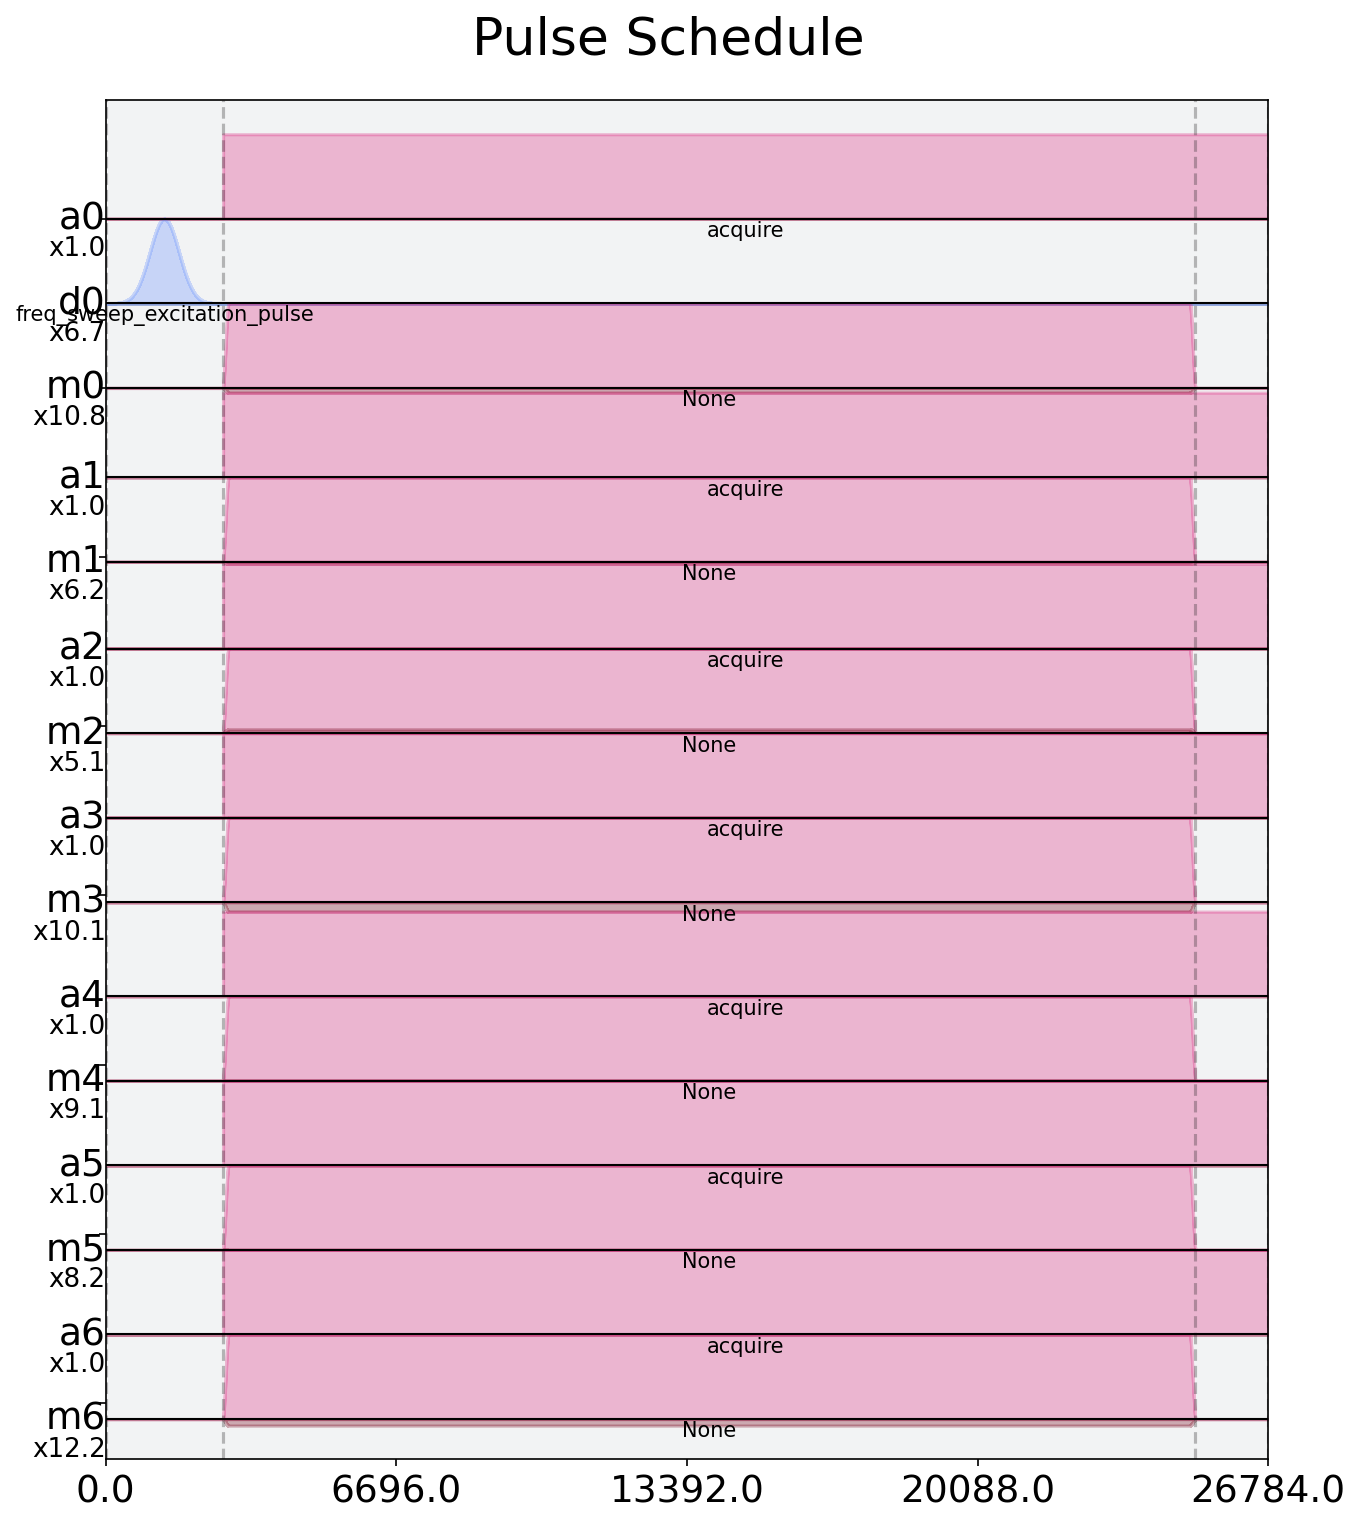

In [14]:
# Drive pulse parameters
drive_sigma_us = 0.075*1e-6             # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8     # This is a truncating parameter, because gaussians don't have a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us /dt)   # The truncating parameter in units of dt
drive_amp = 0.15
drive_pulse = pulse.library.gaussian(sigma=drive_sigma,
                                     duration=drive_samples,
                                     amp=drive_amp,
                                     name='freq_sweep_excitation_pulse')

# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Pulse Schedule')
schedule += pulse.Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration
schedule.draw(label=True)

Below code is to prepare and manipulate the list for data storage. Use with care since it might remove the data you intended to keep!

In [176]:
# joblst, freq_GHzlst = [], []
# joblst.remove(joblst[-1])
# freq_GHzlst.remove(freq_GHzlst[-1])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# joblst, freq_GHzlst = [], []
# num_shots_per_frequency = 1024
# freqswp_program = assemble(experiments=schedule,
#                            backend=backend, 
#                            meas_level=1,
#                            meas_return='avg',
#                            shots=num_shots_per_frequency,
#                            schedule_los=schedule_frequencies)

# job = backend.run(freqswp_program)
# print('job id: {}'.format(job.job_id()))
# job_monitor(job)

# joblst.append(job)
# freq_GHzlst.append(freq_Hz/1e9)

C:\Users\racco\AppData\Roaming\Python\Python37\site-packages\qiskit\compiler\assemble.py:305: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


job id: 5ff4ecd967dbe6001321f700
Job Status: job has successfully run


NameError: name 'joblst' is not defined

Text(0, 0.5, 'Measured signal [a.u.]')

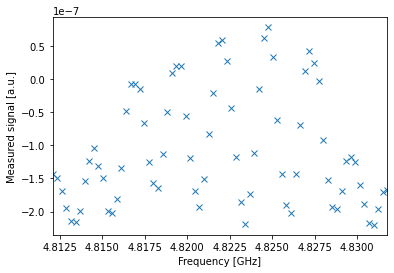

In [18]:
f,ax = plt.subplots()
for j in range(len(joblst)):
    
    freqswp_results = joblst[j].result(timeout=120)
    sweep_values = []
    for i in range(len(freqswp_results.results)): # Get the results from the ith freq
        res = freqswp_results.get_memory(i)*scale_factor
        sweep_values.append(res[qubit])
    
    ax.plot(freq_GHzlst[j], np.real(sweep_values),ls='None',marker='x',alpha=1)
    
ax.set_xlim([min(freq_GHzlst[-1]), max(freq_GHzlst[-1])])
ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("Measured signal [a.u.]")

Text(0, 0.5, 'Measured signal [a.u.]')

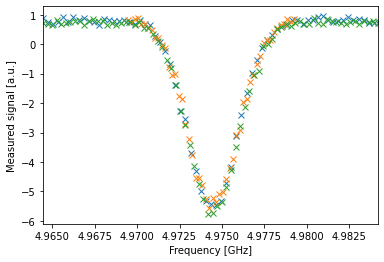

In [182]:
# f,ax = plt.subplots()
# for j in range(len(joblst)):
    
#     freqswp_results = joblst[j].result(timeout=120)
#     sweep_values = []
#     for i in range(len(freqswp_results.results)): # Get the results from the ith freq
#         res = freqswp_results.get_memory(i)*scale_factor
#         sweep_values.append(res[qubit])
    
#     ax.plot(freq_GHzlst[j], np.real(sweep_values),ls='None',marker='x',alpha=1)
    
# ax.set_xlim([min(freq_GHzlst[-1]), max(freq_GHzlst[-1])])
# ax.set_xlabel("Frequency [GHz]")
# ax.set_ylabel("Measured signal [a.u.]")

ok everything looks good, the list was correctly appended.

## Freq sweep with varied amp

Now let's construct a experiment for freq sweep with varied amplitude.

In [24]:
# joblst, freq_GHzlst = [], []

# drive_sigma_us = 0.075*1e-6         
# drive_samples_us = drive_sigma_us*8

# drive_sigma = get_closest_multiple_of_16(drive_sigma_us /dt)     
# drive_samples = get_closest_multiple_of_16(drive_samples_us /dt) 

# drive_amplst = np.linspace(0.1,2,39)
# for drive_amp in drive_amplst:
#     drive_pulse = pulse.library.gaussian(sigma=drive_sigma,
#                                          duration=drive_samples,
#                                          amp=drive_amp,
#                                          name='freq_sweep_excitation_pulse')

#     schedule = pulse.Schedule(name='Pulse Schedule')
#     schedule += pulse.Play(drive_pulse, drive_chan)
#     schedule += measure << schedule.duration

#     num_shots_per_frequency = 1024
#     freqswp_program = assemble(experiments=schedule,
#                                backend=backend, 
#                                meas_level=1,
#                                meas_return='avg',
#                                shots=num_shots_per_frequency,
#                                schedule_los=schedule_frequencies)

#     job = backend.run(freqswp_program)
#     print('job id: {}'.format(job.job_id()))
#     from qiskit.tools.monitor import job_monitor
#     job_monitor(job)

#     joblst.append(job)
#     freq_GHzlst.append(freq_Hz/1e9)

job id: 5fefd30d9b56240019a7b5ef
Job Status: job has successfully run
job id: 5feff9358d763c001aa5becd
Job Status: job has successfully run
job id: 5ff014009c8671001a2b02b0
Job Status: job has successfully run
job id: 5ff0843054c6180019571842
Job Status: job has successfully run
job id: 5ff0a0418d763c001aa5c848
Job Status: job has successfully run
job id: 5ff0b8ca19f73a001a227a32
Job Status: job has successfully run
job id: 5ff0d3fd4a2598001ac5d5e6
Job Status: job has successfully run
job id: 5ff0f19d9c8671001a2b0f76
Job Status: job has successfully run
job id: 5ff11153298e7d001960f07f
Job Status: job has successfully run
job id: 5ff12e2a298e7d001960f19c
Job Status: job has successfully run
job id: 5ff146f19b56240019a7c892
Job Status: job has successfully run
job id: 5ff1bc614a2598001ac5e118
Job Status: job has successfully run
job id: 5ff1cba100eede001aebedfd
Job Status: job has successfully run
job id: 5ff1da669b56240019a7d0c7
Job Status: job has successfully run
job id: 5ff1edfe00ee

PulseError: 'Pulse contains sample with norm greater than 1+epsilon.'

ok so it seems that the Qiskit Pulse doesn't allow amp >1.0. Let's keep that in mind.

## Save the data

To save the data we have many methods, and among those methods I prefer pandas. Let's construct a DataFrame object using pd.

In [147]:
import pandas as pd

Also let's take a look on how many lists we have:
1. joblst
2. freq_GHzlst
3. drive_amplst

So we have joblst with each element contain a job_id where the entire freq scan was performed with freq_GHzlst. And each job_id should be tied with the elements in drive_amplst. I proposed to use the 2D array to store this data set into one large csv file.

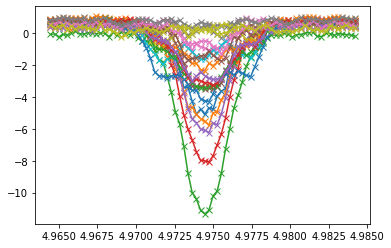

In [144]:
# df = pd.DataFrame(data = freq_GHzlst[0],columns=['Freq (GHz)'])
# for i in range(len(joblst)):
#     result = backend.retrieve_job(joblst[i].job_id()).result(timeout=120)
#     resultlst = []
#     for j in range(len(result.results)):
#         resultlst.append([result.get_memory(j)*scale_factor][qubit][0])
#     df[f'amp {drive_amplst[i]}'] = resultlst

# f,ax = plt.subplots()

# for i in range(len(df.columns)-1):
#     ax.plot(df['Freq (GHz)'], np.real(df[df.columns[i+1]]),
#             label = df.columns[i+1], marker = 'x')
    
# # ax.legend()

In [142]:
df

,Freq (GHz),amp 0.1,amp 0.15,amp 0.2,amp 0.25,amp 0.3,amp 0.35,amp 0.4,amp 0.44999999999999996,amp 0.5,amp 0.5499999999999999,amp 0.6,amp 0.6499999999999999,amp 0.7,amp 0.7499999999999999,amp 0.7999999999999999,amp 0.8499999999999999,amp 0.8999999999999999,amp 0.95,amp 0.9999999999999999
0,4.964452,0.559952-1.647481j,0.360895-1.794675j,-0.093114-1.111621j,0.755215-1.565579j,0.578957-1.720775j,0.575542-1.537624j,0.803163-1.650935j,0.582851-1.504153j,0.725195-1.517351j,0.775814-1.474878j,0.651305-1.436083j,0.859389-1.598697j,0.770940-1.737200j,0.822025-1.672436j,0.359933-1.905181j,0.728553-1.541889j,0.560047-1.749069j,0.815182-1.558723j,0.474345-1.666320j
1,4.964723,0.572936-1.516423j,0.361917-1.788295j,-0.059366-1.173030j,0.676172-1.442619j,0.456499-1.618397j,0.457644-1.674948j,0.702055-1.585587j,0.638854-1.680976j,0.643100-1.578744j,0.723908-1.456766j,0.710348-1.471205j,0.869193-1.468225j,0.719807-1.583514j,0.802986-1.630007j,0.308373-1.937174j,0.659071-1.643220j,0.586325-1.704911j,0.847318-1.515827j,0.319074-1.574694j
2,4.964993,0.555298-1.566529j,0.449687-1.657170j,-0.254309-1.033293j,0.664621-1.453814j,0.317847-1.791624j,0.423591-1.761108j,0.803215-1.553303j,0.484637-1.602518j,0.731843-1.554908j,0.586703-1.422882j,0.647858-1.392413j,0.908970-1.482382j,0.570242-1.681642j,0.699023-1.596668j,0.319154-1.842759j,0.712010-1.561603j,0.688823-1.624994j,0.914913-1.531184j,0.393400-1.650380j
3,4.965263,0.572277-1.492466j,0.437008-1.807442j,-0.086562-1.148094j,0.709950-1.496785j,0.474711-1.842227j,0.583148-1.600919j,0.764039-1.526015j,0.601571-1.574076j,0.659282-1.588668j,0.778495-1.525358j,0.675227-1.508802j,0.907634-1.543645j,0.779195-1.610907j,0.803674-1.650631j,0.308305-1.905799j,0.808403-1.622546j,0.572250-1.808579j,0.981143-1.537686j,0.510782-1.597951j
4,4.965533,0.537336-1.464772j,0.309008-1.720992j,-0.142356-1.152694j,0.547651-1.370570j,0.498179-1.717285j,0.669400-1.535398j,0.763841-1.543200j,0.734628-1.668104j,0.596350-1.569370j,0.796991-1.496694j,0.717796-1.488552j,0.825362-1.485430j,0.795928-1.740332j,0.939765-1.683191j,0.540382-1.821309j,0.751641-1.568613j,0.623622-1.805498j,0.906283-1.560631j,0.176947-1.788790j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,4.983101,0.556692-1.646487j,0.335604-1.904536j,-0.042105-1.170143j,0.621303-1.564087j,0.564645-1.784400j,0.571503-1.808455j,0.877471-1.595166j,0.638271-1.677038j,0.594752-1.565822j,0.817265-1.444594j,0.658209-1.478904j,0.965240-1.540062j,0.743330-1.724287j,0.772578-1.727535j,0.537086-1.782388j,0.586594-1.683104j,0.601207-1.820535j,0.838193-1.494755j,0.253235-1.742857j
70,4.983371,0.358672-1.478859j,0.340951-1.614601j,-0.079581-1.142212j,0.742453-1.475245j,0.410462-1.705008j,0.449032-1.646044j,0.781736-1.575167j,0.575826-1.553467j,0.643162-1.498175j,0.828921-1.549227j,0.577993-1.495804j,0.937957-1.523356j,0.608336-1.762203j,0.797750-1.686540j,0.486881-1.925157j,0.643152-1.695395j,0.638237-1.817031j,1.005926-1.534571j,0.399388-1.630600j
71,4.983642,0.570009-1.517962j,0.475337-1.776633j,-0.104376-1.196381j,0.796851-1.461655j,0.468422-1.643091j,0.569410-1.665972j,0.734321-1.576758j,0.681917-1.580048j,0.638067-1.699700j,0.667461-1.423944j,0.689042-1.491054j,0.813994-1.541687j,0.835410-1.601640j,0.835080-1.626074j,0.341036-1.842752j,0.772438-1.572994j,0.594768-1.672857j,0.914409-1.597070j,0.479265-1.562655j
72,4.983912,0.607106-1.472530j,0.327351-1.748640j,-0.130708-1.128563j,0.677312-1.458922j,0.516117-1.626480j,0.574469-1.786693j,0.719094-1.588772j,0.644654-1.565006j,0.681471-1.536168j,0.734618-1.494571j,0.738384-1.516575j,0.893735-1.531573j,0.776884-1.508263j,0.753893-1.713383j,0.449149-1.687230j,0.544095-1.726295j,0.464361-1.766775j,0.863158-1.505397j,0.298226-1.612707j


Now let's save this df to csv.

In [146]:
# df.to_csv('210104_scanFvariAMP.csv')

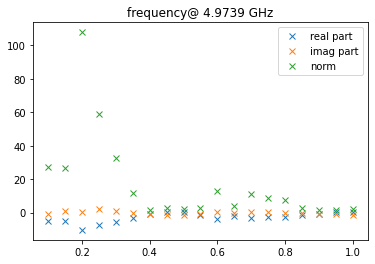

In [250]:
# data_sel = 35

# reallst = np.real(df.iloc[data_sel])[1:]
# imaglst = np.imag(df.iloc[data_sel])[1:]
# ampllst = np.array([i[4:] for i in df.iloc[data_sel].index[1:].to_list()]).astype(np.float)

# f,ax=plt.subplots()
# ax.plot(ampllst,reallst,'x', label='real part')
# ax.plot(ampllst,imaglst,'x', label='imag part')
# ax.plot(ampllst,reallst**2+imaglst**2,'x', label='norm')
# ax.set_title('frequency@ {}GHz'.format(si_format(df['Freq (GHz)'].iloc[data_sel],4)))
# ax.legend()

# What  else to study?
1. pulse amp dependencies
2. IQ heterodyne
3. drive_sigma (pulse duration) dependencies
4. 

In [36]:
from qiskit import QuantumCircuit, execute, BasicAer, ClassicalRegister, QuantumRegister

from qiskit import assemble, transpile
from qiskit.visualization import plot_circuit_layout
from qiskit import schedule as build_schedule
# Be aware that we are importing schedule rather than qiskit.pulse.Schedule

## QC transpiler

In [38]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
provider.backends()

backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()

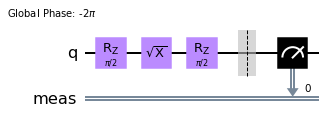

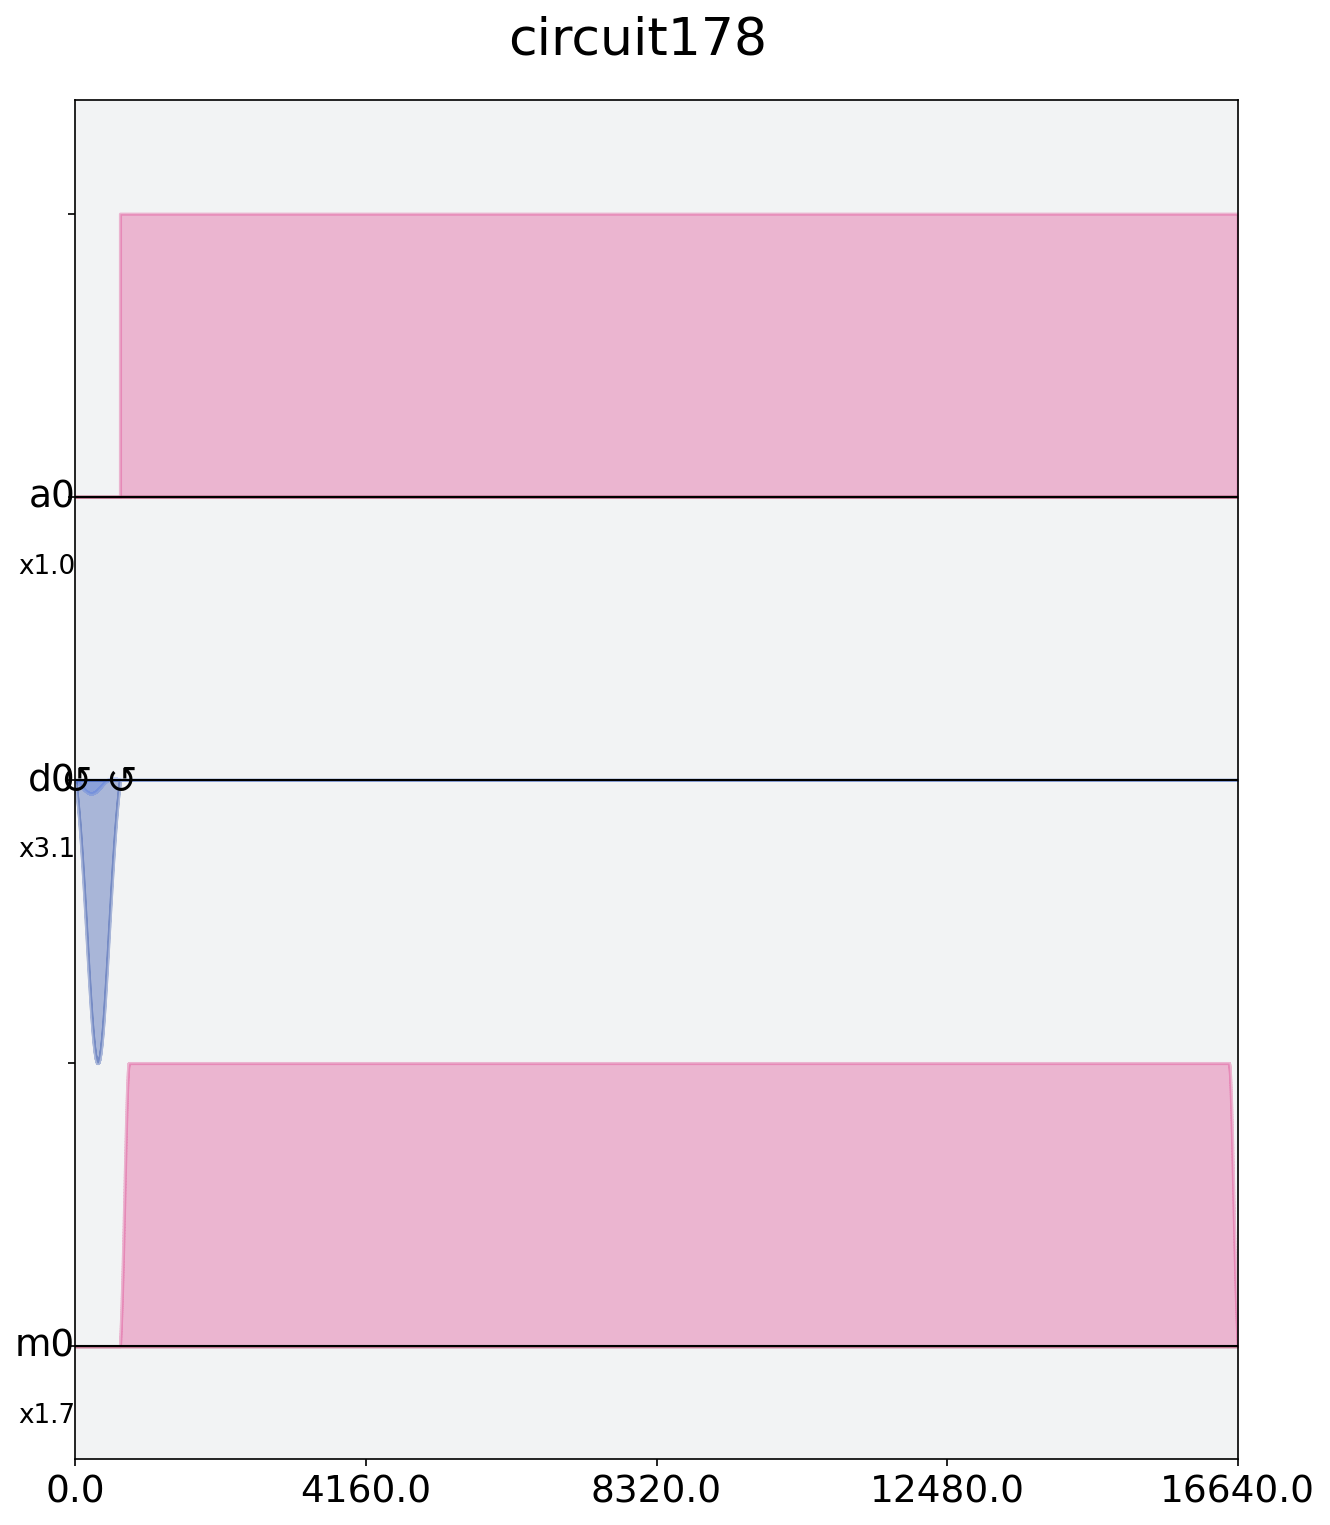

In [44]:
qc = QuantumCircuit(1)
qc.h(0)
qc.measure_all()
qc = transpile(qc, backend)#, optimization_level=0)

BDschedule = build_schedule(qc, backend)

display(qc.draw('mpl'))
# display(plot_circuit_layout(qc, backend))
display(BDschedule.draw())


pulse_qobj = assemble(BDschedule, backend=backend)

# job = backend.run(pulse_qobj)
# print(job.result().get_counts())
# plot_circuit_layout(qc,backend)

**update@(2020/01/04) FakeVigo does not support pulse**

# Multiple qubit circuit layouts

Let's look at the device map level how quantum circuits map to a real device

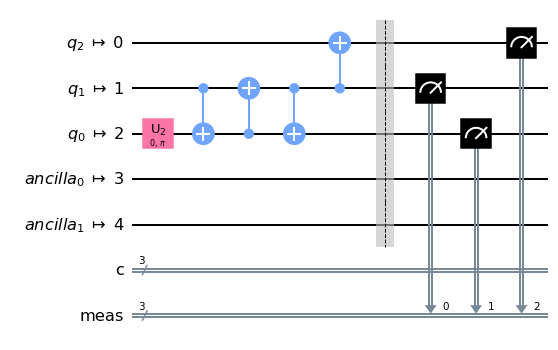

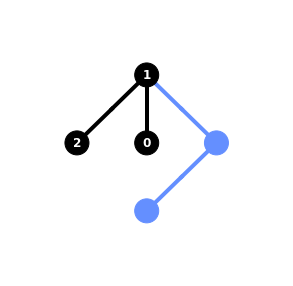

In [47]:
backend = FakeVigo()

qc = QuantumCircuit(3,3)
qc.h(0)
qc.cx(0,2)
qc.measure_all()
qc = transpile(qc, backend)#, optimization_level=0)
#check diff optimization_level to see its effect

display(qc.draw('mpl'))
display(plot_circuit_layout(qc, backend))

# Check Pulse on casablanca

In [49]:
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
provider.backends()

backend = provider.get_backend('ibmq_casablanca')
backend_config = backend.configuration()

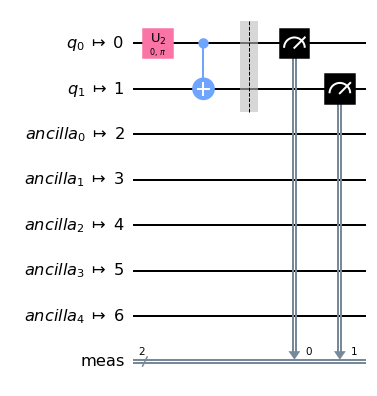

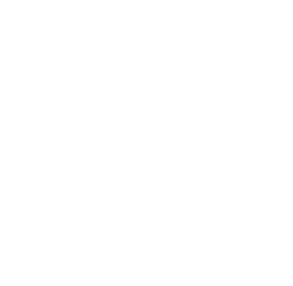

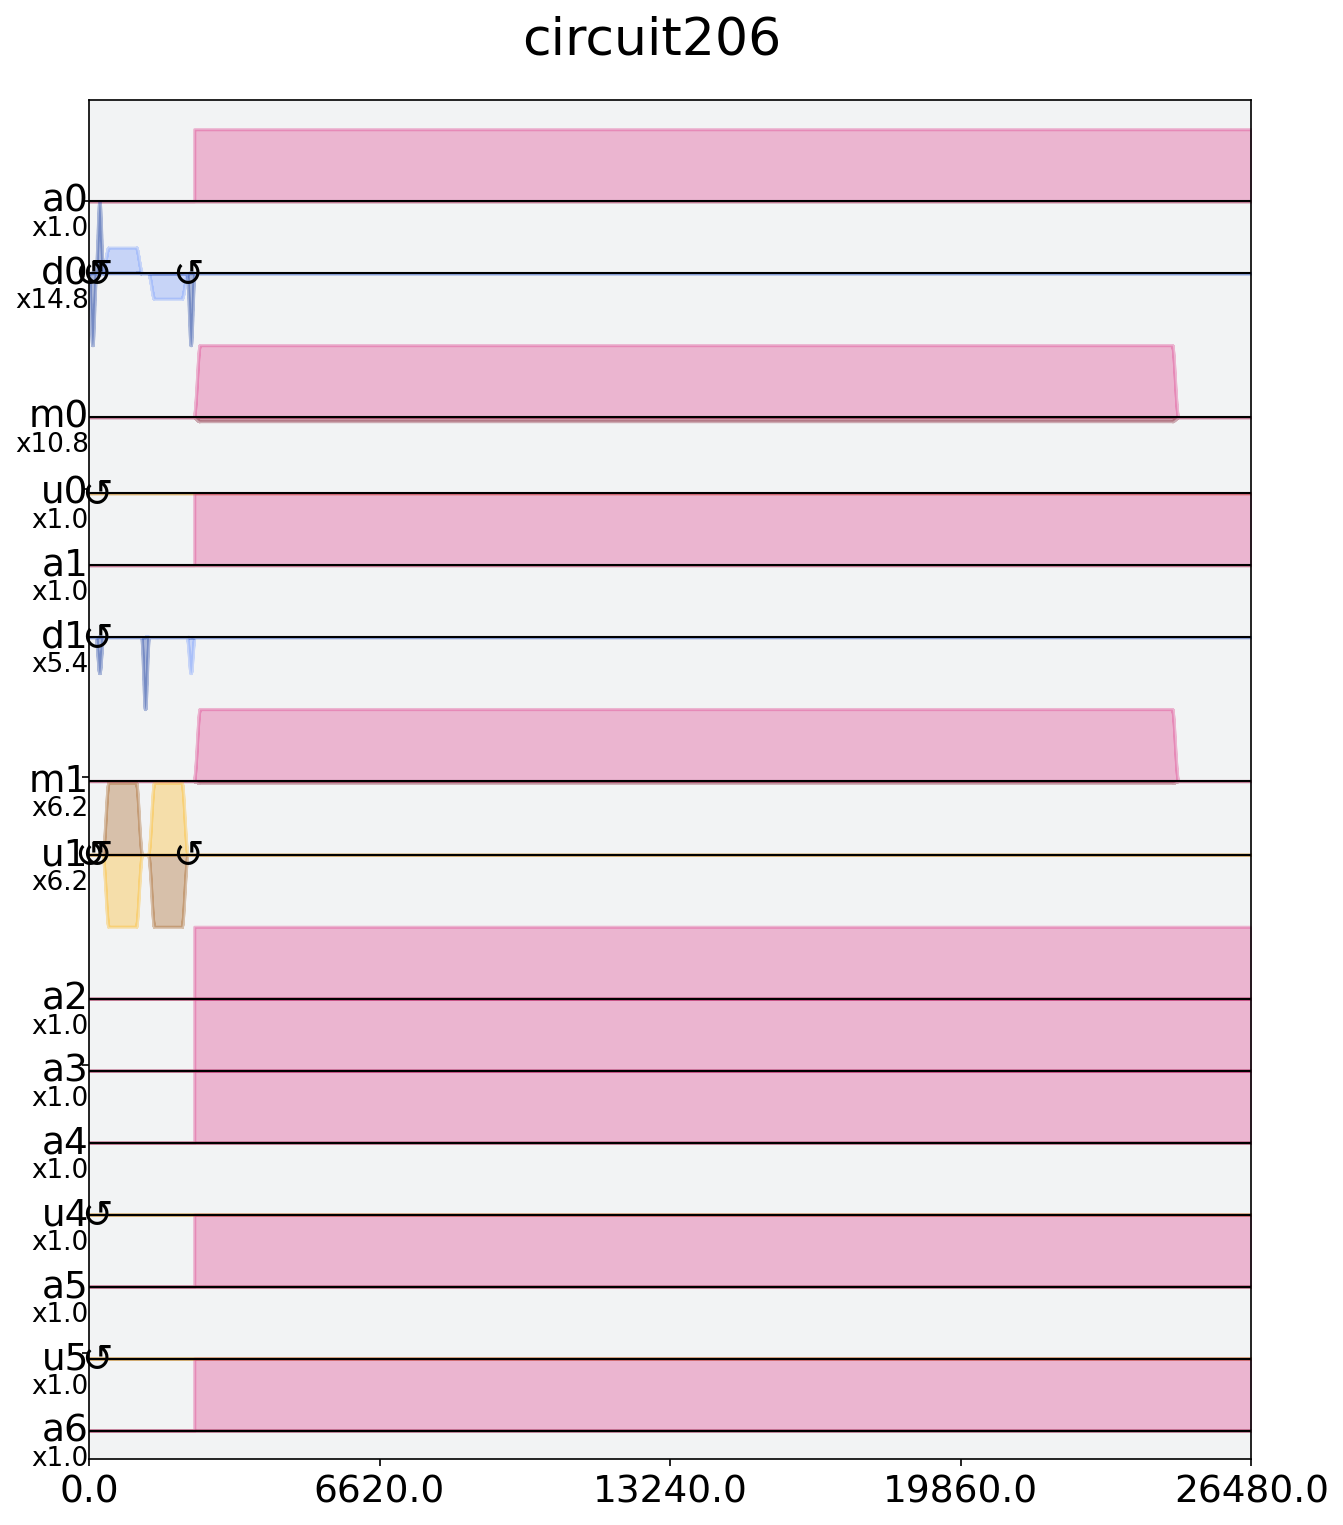

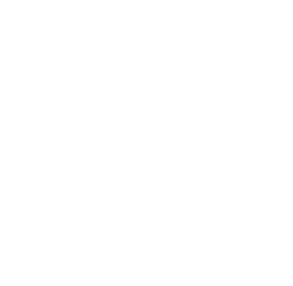

In [50]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
qc = transpile(qc, backend)#, optimization_level=0)

BDschedule = build_schedule(qc, backend)

display(qc.draw('mpl'))
display(plot_circuit_layout(qc, backend))
display(BDschedule.draw())


pulse_qobj = assemble(BDschedule, backend=backend)

# job = backend.run(pulse_qobj)
# print(job.result().get_counts())
# plot_circuit_layout(qc,backend)

# Customized pulse sequence

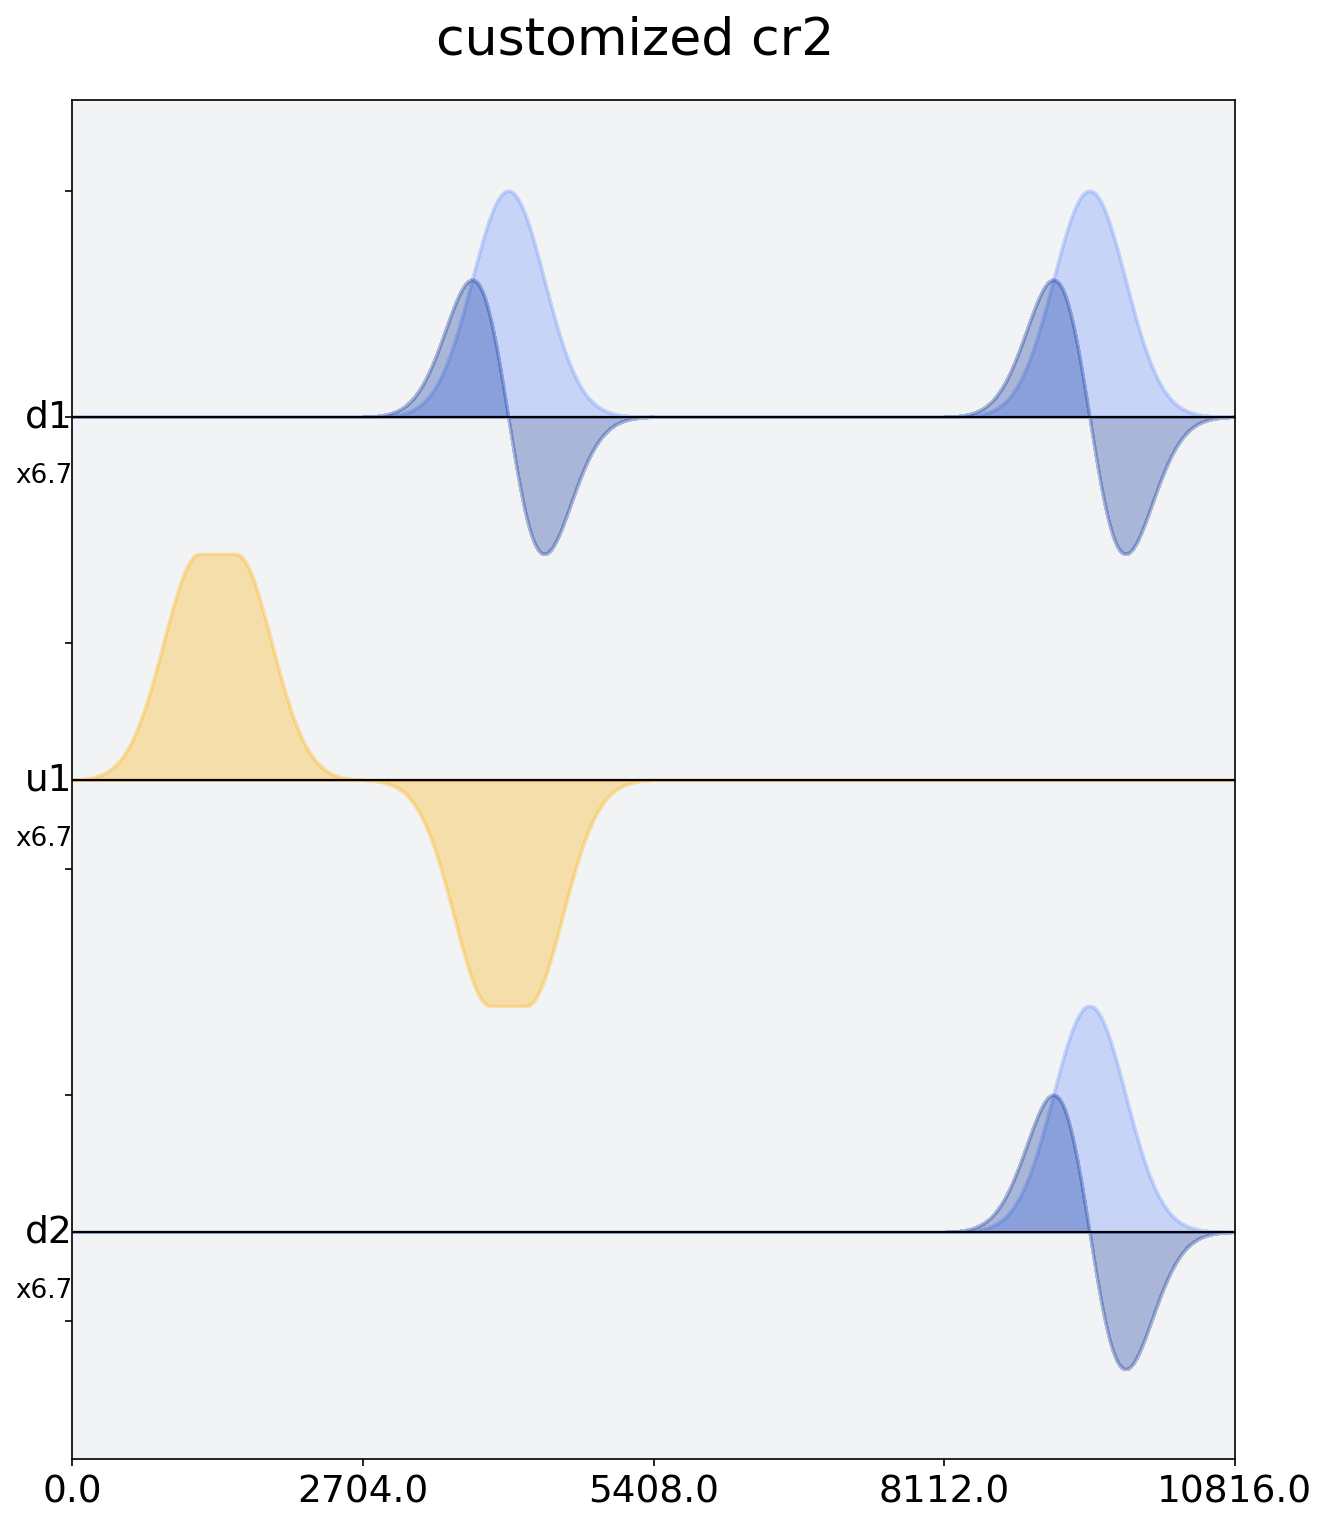

In [27]:
dt = backend_config.dt
drive_sigma_us = 0.075*1e-6
sigma = get_closest_multiple_of_16(drive_sigma_us /dt)
drive_samples_us = drive_sigma_us*8
t_cr = get_closest_multiple_of_16(drive_samples_us /dt)

cr_dur, amp, square_width = t_cr, 0.15, sigma
pi_dur, pi_amp, pi_sigma, pi_beta = t_cr, 0.15, sigma, sigma

driv_chan = pulse.DriveChannel
meas_chan = pulse.MeasureChannel
acqu_chan = pulse.AcquireChannel
ctrl_chan = pulse.ControlChannel

sched = pulse.Schedule(name='customized cr2')
# Create pulse objects for the echoed CR gate
cr_p = pulse.GaussianSquare(cr_dur, amp, sigma, square_width)
cr_m = pulse.GaussianSquare(cr_dur, -amp, sigma, square_width)
x180 = pulse.Drag(pi_dur, pi_amp, pi_sigma, pi_beta)

# Assemble the schedule
sched += pulse.Play (cr_p, ctrl_chan(1))
sched += pulse.Delay(t_cr, driv_chan(1))
sched += pulse.Play (x180, driv_chan(1))
sched += pulse.Play (cr_m, ctrl_chan(1))
sched += pulse.Delay(t_cr, driv_chan(1))
sched += pulse.Play (x180, driv_chan(1))

sched += pulse.Delay(t_cr*3, driv_chan(2))
sched += pulse.Play (x180, driv_chan(2))

sched.draw()

# Our practice

To better understand the peak level difference at different simplitude we would likt to plot everything together

<IPython.core.display.Javascript object>


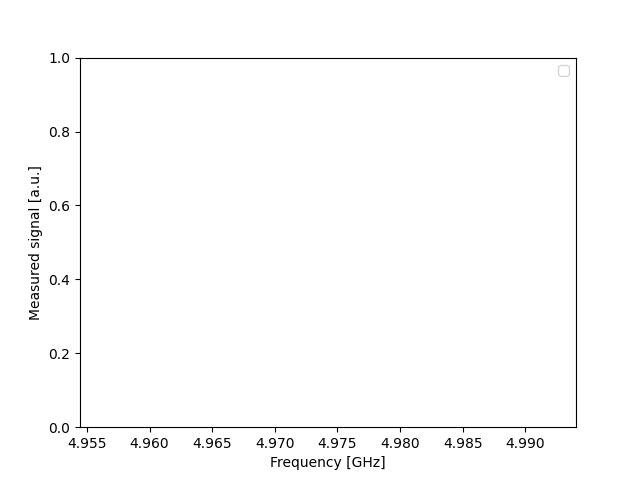

No handles with labels found to put in legend.


In [22]:
%matplotlib notebook

f,ax = plt.subplots()
ax.set_xlim([min(frequencies_GHz), max(frequencies_GHz)])
ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("Measured signal [a.u.]")
ax.legend()

In [23]:
amp_list = np.arange(0.1,0.15,0.05)
for amp in amp_list:
    # The sweep will be centered around the estimated qubit frequency.
    center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                        # warning: this will change in a future release
    print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

    # scale factor to remove factors of 10 from the data
    scale_factor = 1e-14

    # We will sweep 30 MHz around the estimated frequency
    frequency_span_Hz = 20 * MHz
    # in steps of 400 kHz.
    frequency_step_Hz = 0.40 * MHz

    # We will sweep 20 MHz above and 20 MHz below the estimated frequency
    frequency_min = center_frequency_Hz - frequency_span_Hz / 2
    frequency_max = center_frequency_Hz + frequency_span_Hz / 2
    # Construct an np array of the frequencies for our experiment
    frequencies_GHz = np.arange(frequency_min / GHz, 
                                frequency_max / GHz, 
                                frequency_step_Hz / GHz)

    print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
    in steps of {frequency_step_Hz / MHz} MHz.")

    # Drive pulse parameters (us = microseconds)
    drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
    drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                               # a natural finite length

    drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
    drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
    drive_amp = amp
    # Drive pulse samples
    drive_pulse = pulse.library.gaussian(duration=drive_samples,
                                     sigma=drive_sigma,
                                     amp=drive_amp,
                                     name='freq_sweep_excitation_pulse')

    job = backend.run(frequency_sweep_program)
    job_monitor(job)
    frequency_sweep_results = job.result(timeout=60*60) # timeout parameter set to 120 seconds

    sweep_values = []
    for i in range(len(frequency_sweep_results.results)):
        # Get the results from the ith experiment
        res = frequency_sweep_results.get_memory(i)*scale_factor
        # Get the results for `qubit` from this experiment
        sweep_values.append(res[qubit])

    ax.plot(frequencies_GHz, np.real(sweep_values), marker = 'dot', label = 'amp={:.3}'.format(drive_amp))

Qubit 0 has an estimated frequency of 4.974452361343912 GHz.
The sweep will go from 4.964452361343912 GHz to 4.984452361343912 GHz     in steps of 0.4 MHz.


NameError: name 'frequency_sweep_program' is not defined

to do: check python file I/O to record data

The end of the test

In [ ]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [17]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.975, 1, 3] # initial parameters for curve_fit
                                )

NameError: name 'sweep_values' is not defined

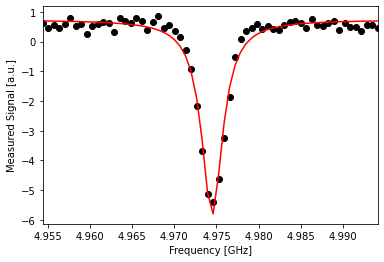

In [24]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [25]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97445 GHz to 4.97449 GHz.


In [42]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.35
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [43]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse.library.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += pulse.Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

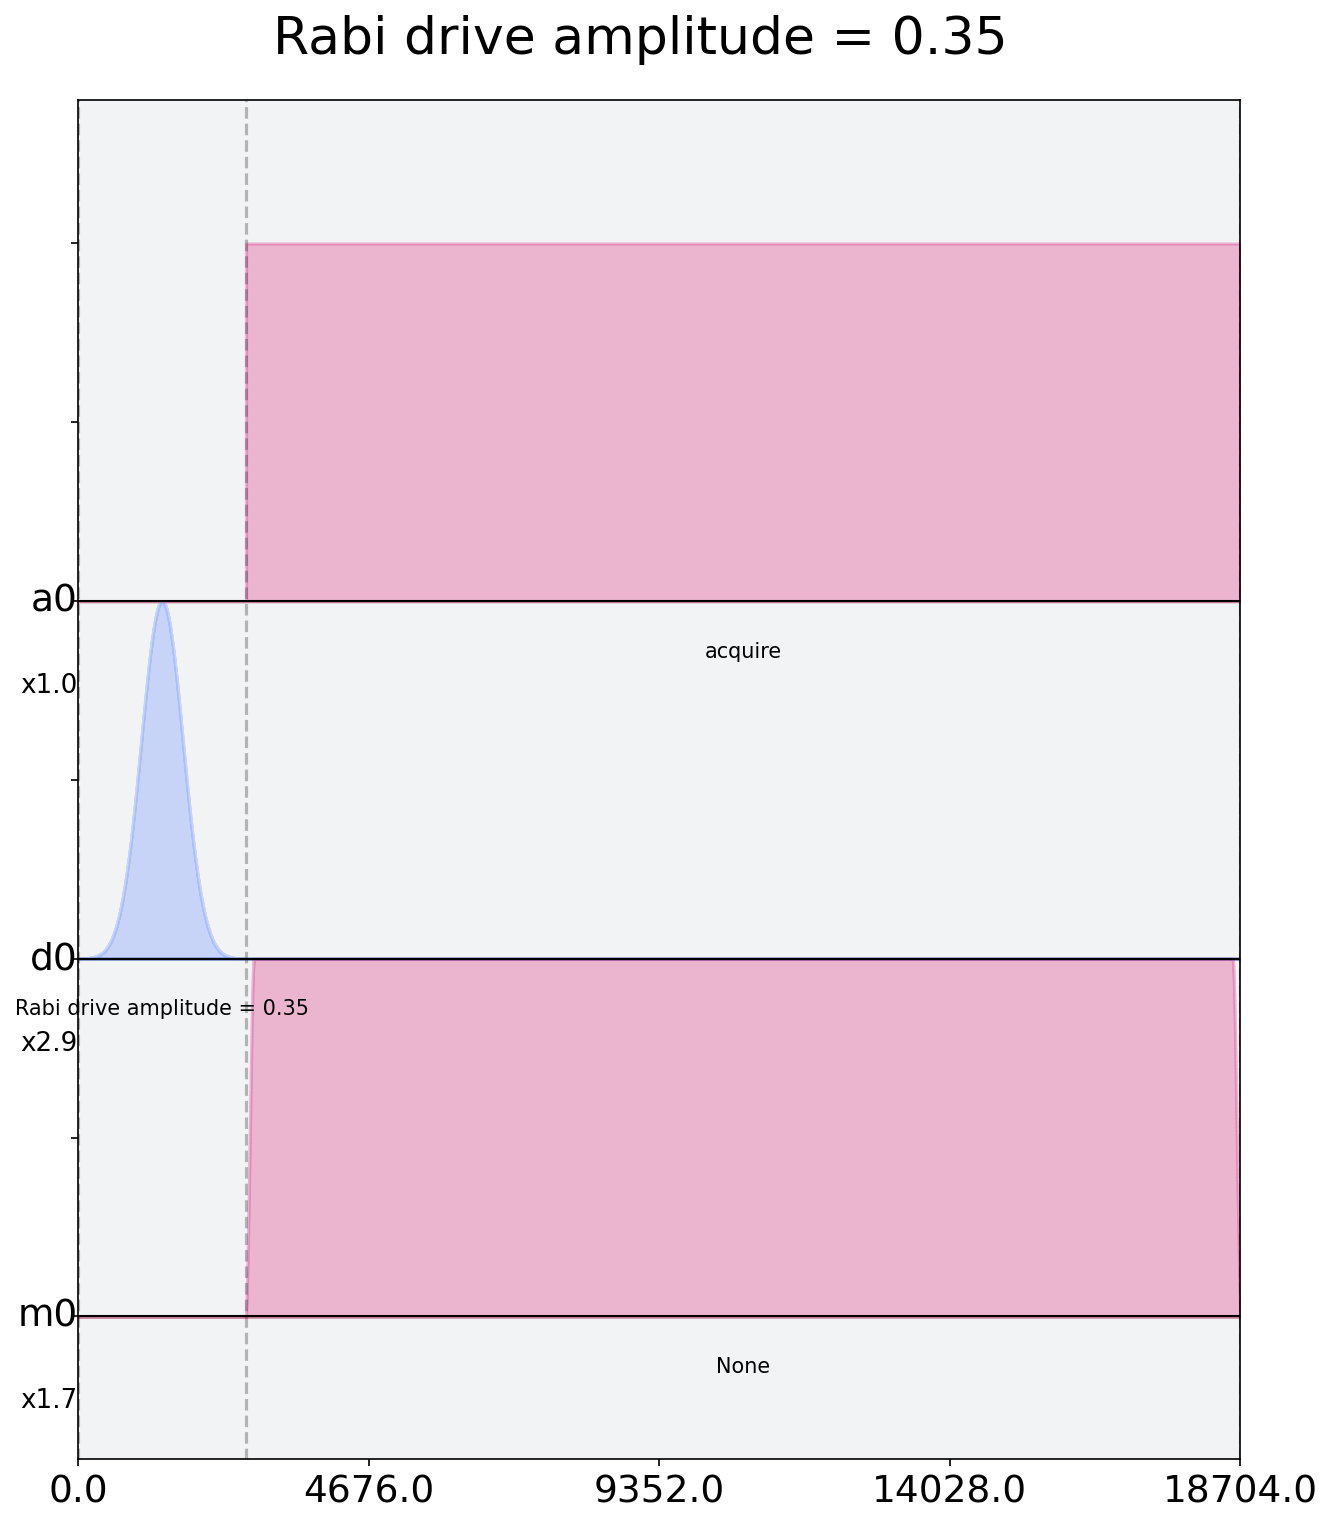

In [44]:
rabi_schedules[-1].draw(label=True)

In [45]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

In [46]:
print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

5fdf2142540cbd00192cb71f
Job Status: job has successfully run


In [47]:
rabi_results = job.result(timeout=120)

In [48]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

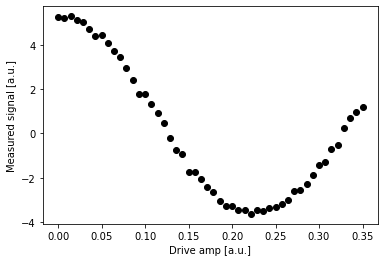

In [49]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()